线性回归从0开始实现

In [51]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

根据带有噪声的线性模型构造一个人造数据集。我们使用线性模型参数w=[2,-3.4],b=4.2和噪声epsilon生成数据集极其标签：y=xw+b+e

In [52]:
def synthetic_data(w, b, num_examples):
    #"生成y=xw+b+噪声"
    x =torch.normal(0, 1, (num_examples,len(w)))
    y = torch.matmul(x, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return x, y.reshape((-1,1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

features中的每一行都包含一个二维数据样本，labels中的每一行都包含一维标签值（一个标量）

In [53]:
print('features:',features[0],'\nlabel:',labels[0])

features: tensor([ 1.0610, -0.6083]) 
label: tensor([8.3942])


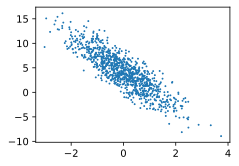

In [54]:
d2l.set_figsize()
# detach 把变量从计算图中剥离出来，才可以计算numpy
d2l.plt.scatter(features[:,1].detach().numpy(),labels.detach().numpy(),1);

定义一个data_iter函数，该函数接受批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量。

In [55]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices) # 这些样本是随机读取的，没有特定的顺序
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i+batch_size,num_examples)])
        yield features[batch_indices], labels[batch_indices]
        
batch_size = 10

for x, y in data_iter(batch_size, features, labels):
    print(x, '\n', y)
    break
   

tensor([[ 0.0266, -0.3267],
        [-1.6280, -0.2146],
        [ 1.7047,  0.5076],
        [-1.6832, -0.4868],
        [ 0.0212, -0.5591],
        [-0.3867,  0.1001],
        [-1.3893,  0.8560],
        [-0.1797, -0.2630],
        [-0.3667, -1.3951],
        [-0.1755, -1.3195]]) 
 tensor([[ 5.3637],
        [ 1.7010],
        [ 5.8790],
        [ 2.4925],
        [ 6.1489],
        [ 3.0862],
        [-1.5151],
        [ 4.7342],
        [ 8.1737],
        [ 8.3375]])


定义初始化模型参数

In [56]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad = True)
b = torch.zeros(1, requires_grad=True)
w,b

(tensor([[ 0.0012],
         [-0.0028]], requires_grad=True),
 tensor([0.], requires_grad=True))

定义模型

In [57]:
def linreg(X, w, b):
    '''线性回归模型'''
    return torch.matmul(X, w) + b

定义损失函数

In [58]:
def squared_loss(y_hat, y):
    '''均方损失'''
    return (y_hat - y.reshape(y_hat.shape))**2 /2

定义优化算法

In [59]:
def sgd(params, lr, batch_size):
    '''小批量随机梯度下降,更新时不用参与梯度计算'''
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size 
            '''因为我们计算损失是一个批量样本的总和，
            所以用批量大小来归一化步长，这样步长大小就不会取决于对批量大小的选择'''
            param.grad.zero_() #pytoch不会自动帮你把梯度设为0,这样下一步计算梯度就不会和上一步相关了
            

训练过程

In [63]:
lr = 0.03
num_epochs = 3
net = linreg 
loss =squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels): # 拿出一个批量大小的x和y
        l  =loss(net(X, w, b),y) # l为长为批量大小的一个向量
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新
    with torch.no_grad(): # 这里评价下进度，测试这部分是不需要做梯度的
            train_l = loss(net(features, w, b), labels)
            print(f'epoch{epoch+1}, loss{float(train_l.mean())}')

epoch1, loss5.0873120926553383e-05
epoch2, loss5.0851664127549157e-05
epoch3, loss5.094699008623138e-05


比较真是参数和通过训练学到的参数来评估训练的成功程度

In [61]:
print(f'w的估计误差：{true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差： {true_b - b}')

w的估计误差：tensor([-0.0002, -0.0002], grad_fn=<SubBackward0>)
b的估计误差： tensor([-0.0006], grad_fn=<RsubBackward1>)
